In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# copy code folders there for better access
!cp -r drive/MyDrive/KNN/baseline .
!cp -r drive/MyDrive/KNN/datasets .
!cp -r drive/MyDrive/KNN/distillation .
!cp -r drive/MyDrive/KNN/eval .
!cp -r drive/MyDrive/KNN/lightweight .

In [ ]:
# remove directory if necessary
!rm -r -f ./data

In [ ]:
# unzip datasets
# UNCOMMENT ONLY THE ONE YOU NEED - otherwise it will take too long ...
!mkdir data
!unzip -P CVPR16_IDM@PKU /content/drive/MyDrive/KNN/VehicleID_V1.0.zip -d ./data
# !unzip drive/MyDrive/KNN/VeriWild.zip -d ./data
# !unzip drive/MyDrive/CODE/KNN/VeRi.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/VehicleID_V1.0/image/0320127.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320128.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320129.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320130.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320132.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320133.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320134.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320135.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320136.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320137.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320139.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320142.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320143.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320145.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320146.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320147.jpg  
  inflating: ./data/VehicleID_V1.0/image/0320148.jpg  
  inflating: .

## OWN CODE

In [3]:
# IMPORTS

DEVICE_NOTCPU = "cpu"

import sys
sys.path.insert(0, 'eval')
import math
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import copy
from tqdm import tqdm
import time
from torchvision import transforms
from torch.utils.data import DataLoader
from typing import OrderedDict
import torch.multiprocessing
import yaml
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

import matplotlib.pyplot as plt
from eval import eval_func
from baseline import MBR_model, ClassBlock, Bottleneck_Transformer, MHSA, weights_init_kaiming, weights_init_classifier
from triplet_sampler import train_collate_fn, CustomDataSet4VERIWILD, CustomDataSet4VERIWILDv2, RandomIdentitySampler, CustomDataSet4Market1501, CustomDataSet4Veri776, CustomDataSet4Veri776_withviewpont, CustomDataSet4VehicleID_Random, CustomDataSet4VehicleID
from eval import re_ranking, get_model, normalize_batch, test_epoch
import torch.optim as optim
from datetime import datetime

In [4]:
class IBN(nn.Module):
    r"""Instance-Batch Normalization layer from
    `"Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net"
    <https://arxiv.org/pdf/1807.09441.pdf>`

    Args:
        planes (int): Number of channels for the input tensor
        ratio (float): Ratio of instance normalization in the IBN layer
    """
    def __init__(self, planes, ratio=0.5):
        super(IBN, self).__init__()
        self.half = int(planes * ratio)
        self.IN = nn.InstanceNorm2d(self.half, affine=True)
        self.BN = nn.BatchNorm2d(planes - self.half)

    def forward(self, x):
        split = torch.split(x, self.half, 1)
        out1 = self.IN(split[0].contiguous())
        out2 = self.BN(split[1].contiguous())
        out = torch.cat((out1, out2), 1)
        return out


class Bottleneck_IBN(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, ibn=None, stride=1, downsample=None):
        super(Bottleneck_IBN, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        if ibn == 'a':
            self.bn1 = IBN(planes)
        else:
            self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.IN = nn.InstanceNorm2d(planes * 4, affine=True) if ibn == 'b' else None
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.IN is not None:
            out = self.IN(out)
        out = self.relu(out)

        return out


class ResNet_IBN(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 ibn_cfg=('a', 'a', 'a', None),
                 num_classes=1000):
        self.inplanes = 64
        super(ResNet_IBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        if ibn_cfg[0] == 'b':
            self.bn1 = nn.InstanceNorm2d(64, affine=True)
        else:
            self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], ibn=ibn_cfg[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, ibn=ibn_cfg[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, ibn=ibn_cfg[2])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, ibn=ibn_cfg[3])
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, ibn=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes,
                            None if ibn == 'b' else ibn,
                            stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                None if (ibn == 'b' and i < blocks-1) else ibn))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class base_branches(nn.Module):
    # This class differs in first else branch, if torch cuda is added
    def __init__(self, backbone="ibn", stride=1):
        super(base_branches, self).__init__()
        if backbone == 'r50':
            model_ft = models.resnet50()
        elif backbone == '101ibn':
            model_ft = torch.hub.load('XingangPan/IBN-Net', 'resnet101_ibn_a', pretrained=True)# 'resnet50_ibn_a'
        elif backbone == '34ibn':
            model_ft = torch.hub.load('XingangPan/IBN-Net', 'resnet34_ibn_a', pretrained=True)# 'resnet50_ibn_a'
        else:
            # This part is different against baseline.py base_branches func
            if torch.cuda.is_available():
                model_ft = torch.hub.load('XingangPan/IBN-Net', 'resnet50_ibn_a', pretrained=True)
            else:
                _model = ResNet_IBN(block=Bottleneck_IBN,
                        layers=[3, 4, 6, 3],
                        ibn_cfg=('a', 'a', 'a', None))
                _model.load_state_dict(torch.hub.load_state_dict_from_url('https://github.com/XingangPan/IBN-Net/releases/download/v1.0/resnet50_ibn_a-d9d0bb7b.pth', map_location='cpu'))
                model_ft = _model

        if stride == 1:
            model_ft.layer4[0].downsample[0].stride = (1,1)
            if backbone == "34ibn":
                model_ft.layer4[0].conv1.stride = (1,1)
            else:
                model_ft.layer4[0].conv2.stride = (1,1)

        self.model = torch.nn.Sequential(*(list(model_ft.children())[:-3]))

    def forward(self, x):
        x = self.model(x)
        return x


class multi_branches(nn.Module):
    # Again different against our func in if torch cuda
    def __init__(self, n_branches, n_groups, pretrain_ongroups=True, end_bot_g=False, group_conv_mhsa=False, group_conv_mhsa_2=False, x2g = False, x4g=False):
        super(multi_branches, self).__init__()

        # Here is the difference
        if torch.cuda.is_available():
            model_ft = torch.hub.load('XingangPan/IBN-Net', 'resnet50_ibn_a', pretrained=True)
        else:
            _model = ResNet_IBN(block=Bottleneck_IBN,
                        layers=[3, 4, 6, 3],
                        ibn_cfg=('a', 'a', 'a', None))
            _model.load_state_dict(torch.hub.load_state_dict_from_url('https://github.com/XingangPan/IBN-Net/releases/download/v1.0/resnet50_ibn_a-d9d0bb7b.pth', map_location='cpu'))
            model_ft = _model

        model_ft= model_ft.layer4
        self.x2g = x2g
        self.x4g = x4g
        if n_groups > 0:
            convlist = [k.split('.') for k, m in model_ft.named_modules(remove_duplicate=False) if isinstance(m, nn.Conv2d)]
            for item in convlist:
                if item[1] == "downsample":
                    m = model_ft[int(item[0])].get_submodule(item[1])[0]
                else:
                    m = model_ft[int(item[0])].get_submodule(item[1]) #'.'.join(
                weight = m.weight[:int(m.weight.size(0)), :int(m.weight.size(1)/n_groups), :,:]
                if item[1] == "downsample":
                    getattr(model_ft[int(item[0])], item[1])[0] = nn.Conv2d(int(m.weight.size(1)), int(m.weight.size(0)), kernel_size=1, stride=1, groups=n_groups, bias=False).apply(weights_init_kaiming)
                    if pretrain_ongroups:
                        getattr(model_ft[int(item[0])], item[1])[0].weight.data = weight
                elif item[1] == "conv2":
                    setattr(model_ft[int(item[0])], item[1], nn.Conv2d(int(m.weight.size(1)), int(m.weight.size(0)), kernel_size=3, stride=1, padding=(1,1), groups=n_groups, bias=False).apply(weights_init_kaiming))
                    if pretrain_ongroups:
                        setattr(model_ft[int(item[0])].get_submodule(item[1]).weight, "data", weight)
                else:
                    setattr(model_ft[int(item[0])], item[1], nn.Conv2d(int(m.weight.size(1)), int(m.weight.size(0)), kernel_size=1, stride=1, groups=n_groups, bias=False).apply(weights_init_kaiming))
                    if pretrain_ongroups:
                        setattr(model_ft[int(item[0])].get_submodule(item[1]).weight, "data", weight)
        self.model = nn.ModuleList()

        if len(n_branches) > 0:
            if n_branches[0] == "2x":
                self.model.append(model_ft)
                self.model.append(copy.deepcopy(model_ft))
            else:
                for item in n_branches:
                    if item =="R50":
                        self.model.append(copy.deepcopy(model_ft))
                    elif item == "BoT":
                        layer_0 = Bottleneck_Transformer(1024, 512, resolution=[16, 16], use_mlp = False)
                        layer_1 = Bottleneck_Transformer(2048, 512, resolution=[16, 16], use_mlp = False)
                        layer_2 = Bottleneck_Transformer(2048, 512, resolution=[16, 16], use_mlp = False)
                        self.model.append(nn.Sequential(layer_0, layer_1, layer_2))
                    else:
                        print("No valid architecture selected for branching by expansion!")
        else:
            self.model.append(model_ft)


    def forward(self, x):
        output = []
        for cnt, branch in enumerate(self.model):
            if self.x2g and cnt>0:
                aux = torch.cat((x[:,int(x.shape[1]/2):,:,:], x[:,:int(x.shape[1]/2),:,:]), dim=1)
                output.append(branch(aux))
            elif self.x4g and cnt>0:
                aux = torch.cat((x[:,int(x.shape[1]/4):int(x.shape[1]/4*2),:,:], x[:, :int(x.shape[1]/4),:,:], x[:, int(x.shape[1]/4*3):,:,:], x[:, int(x.shape[1]/4*2):int(x.shape[1]/4*3),:,:]), dim=1)
                output.append(branch(aux))
            else:
                output.append(branch(x))

        return output


class FinalLayer(nn.Module):
    # In this function, if self.withLAI branch is removed compared to our FinalLayer
    def __init__(self, class_num, n_branches, n_groups, losses="LBS", droprate=0, linear_num=False, return_f = True, circle_softmax=False, n_cams=0, n_views=0, LAI=False, x2g=False,x4g=False):
        super(FinalLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.finalblocks = nn.ModuleList()
        self.withLAI = LAI
        if n_groups > 0:
            self.n_groups = n_groups
            for i in range(n_groups*(len(n_branches)+1)):
                if losses == "LBS":
                    if i%2==0:
                        self.finalblocks.append(ClassBlock(int(2048/n_groups), class_num, droprate, linear=linear_num, return_f = return_f, circle=circle_softmax))
                    else:
                        bn= nn.BatchNorm1d(int(2048/n_groups))
                        bn.bias.requires_grad_(False)
                        bn.apply(weights_init_kaiming)
                        self.finalblocks.append(bn)
                else:
                    self.finalblocks.append(ClassBlock(int(2048/n_groups), class_num, droprate, linear=linear_num, return_f = return_f, circle=circle_softmax))
        else:
            self.n_groups = 1
            for i in range(len(n_branches)):
                if losses == "LBS":
                    if i%2==0:
                        self.finalblocks.append(ClassBlock(2048, class_num, droprate, linear=linear_num, return_f = return_f, circle=circle_softmax))
                    else:
                        bn= nn.BatchNorm1d(int(2048))
                        bn.bias.requires_grad_(False)
                        bn.apply(weights_init_kaiming)
                        self.finalblocks.append(bn)
                else:
                    self.finalblocks.append(ClassBlock(2048, class_num, droprate, linear=linear_num, return_f = return_f, circle=circle_softmax))

        if losses == "LBS":
            self.LBS = True
        else:
            self.LBS = False

    def forward(self, x, cam, view):
        # if len(x) != len(self.finalblocks):
        #     print("Something is wrong")
        embs = []
        ffs = []
        preds = []
        for i in range(len(x)):
            emb = self.avg_pool(x[i]).squeeze(dim=-1).squeeze(dim=-1)
            for j in range(self.n_groups):
                aux_emb = emb[:,int(2048/self.n_groups*j):int(2048/self.n_groups*(j+1))]
                if self.LBS:
                    if (i+j)%2==0:
                        pred, ff = self.finalblocks[i+j](aux_emb)
                        ffs.append(ff)
                        preds.append(pred)
                    else:
                        ff = self.finalblocks[i+j](aux_emb)
                        embs.append(aux_emb)
                        ffs.append(ff)
                else:
                    aux_emb = emb[:,int(2048/self.n_groups*j):int(2048/self.n_groups*(j+1))]
                    pred, ff = self.finalblocks[i+j](aux_emb)
                    embs.append(aux_emb)
                    ffs.append(ff)
                    preds.append(pred)

        return preds, embs, ffs


class LightNN_MBR_4B_Hybrid(nn.Module):
    def __init__(self, class_num, n_branches, n_groups, losses="LBS", backbone="ibn", droprate=0, linear_num=False, return_f = True, circle_softmax=False, pretrain_ongroups=True, end_bot_g=False, group_conv_mhsa=False, group_conv_mhsa_2=False, x2g=False, x4g=False, LAI=False, n_cams=0, n_views=0):
        super(LightNN_MBR_4B_Hybrid, self).__init__()
        self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
        self.backbone.classifier = nn.Sequential()

        self.multiSimulator = nn.Sequential(
            nn.Linear(576, 8192),
            nn.BatchNorm1d(8192)
        )

        self.classifier = nn.Sequential(
            nn.Linear(8192, class_num, bias=True)
            # nn.Linear(2048, 1024, bias=True),
            # nn.Hardswish(),
            # nn.Dropout(p=0.2, inplace=True),
            # nn.Linear(1024, class_num, bias=True)
        )

        # self.model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
        # self.model.classifier = nn.Sequential(
        #     nn.Linear(576, 2048),
        #     nn.BatchNorm1d(2048)
        # )

    def forward(self, x,cam, view):
        # out = self.model(x)
        # return None, None, [out], [torch.empty(out.shape[0])]
        backboneOut = self.backbone(x)
        ffs = self.multiSimulator(backboneOut)
        pred = self.classifier(ffs)
        return pred, None, [ffs], [torch.empty(ffs.shape[0])]

class LightNN(nn.Module):
    def __init__(self, class_num, n_branches, n_groups, losses="LBS", backbone="ibn", droprate=0, linear_num=False, return_f = True, circle_softmax=False, pretrain_ongroups=True, end_bot_g=False, group_conv_mhsa=False, group_conv_mhsa_2=False, x2g=False, x4g=False, LAI=False, n_cams=0, n_views=0):
        super(LightNN, self).__init__()
        self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights)
        self.backbone.classifier = nn.Sequential()

        self.multiSimulator = nn.Sequential(
            nn.Linear(576, 2048),
            nn.BatchNorm1d(2048)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, class_num, bias=True)
        )

    def forward(self, x,cam, view):
        # out = self.model(x)
        # return None, None, [out], [torch.empty(out.shape[0])]
        backboneOut = self.backbone(x)
        ffs = self.multiSimulator(backboneOut)
        pred = self.classifier(ffs)
        return pred, None, [ffs], [torch.empty(ffs.shape[0])]

class LightNN_LargeV3(nn.Module):
    def __init__(self, class_num, n_branches, n_groups, losses="LBS", backbone="ibn", droprate=0, linear_num=False, return_f = True, circle_softmax=False, pretrain_ongroups=True, end_bot_g=False, group_conv_mhsa=False, group_conv_mhsa_2=False, x2g=False, x4g=False, LAI=False, n_cams=0, n_views=0):
        super(LightNN_LargeV3, self).__init__()
        self.backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        self.backbone.classifier = nn.Sequential()

        self.multiSimulator = nn.Sequential(
            nn.Linear(960, 2048),
            nn.BatchNorm1d(2048)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, class_num, bias=True)
        )



    def forward(self, x,cam, view):
        # out = self.model(x)
        # return None, None, [out], [torch.empty(out.shape[0])]
        backboneOut = self.backbone(x)
        ffs = self.multiSimulator(backboneOut)
        pred = self.classifier(ffs)
        return pred, None, [ffs], [torch.empty(ffs.shape[0])]

def getDatasetInParts(path, data, test_transform, train_transform, dataset='VERIWILD'):
    """
    Args:
        path : path to the root folder of the dataset (not to exact files!)
        dataset : [VERIWILD|VehicleID|Veri776]
    Return:
        data_train, data_g, data_q
    """

    ## Dataset Loading
    if dataset == "VehicleID":
        data_q = CustomDataSet4VehicleID(path+'/train_test_split/test_list_800.txt', path+'/image/', is_train=False, mode="q", transform=test_transform)
        data_g = CustomDataSet4VehicleID(path+'/train_test_split/test_list_800.txt', path+'/image/', is_train=False, mode="g", transform=test_transform)
        data_train = CustomDataSet4VehicleID(path+"/train_test_split/train_list.txt", path+'/image/', is_train=True, transform=train_transform)
        data_train = DataLoader(data_train, sampler=RandomIdentitySampler(data_train, data['BATCH_SIZE'], data['NUM_INSTANCES']), num_workers=data['num_workers_train'], batch_size = data['BATCH_SIZE'], collate_fn=train_collate_fn, pin_memory=True)#
        data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
        data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
    if dataset == 'VERIWILD':
        data_q = CustomDataSet4VERIWILD(path+'/train_test_split/test_3000_id_query.txt', path+'/images/', transform=test_transform, with_view=False)
        data_g = CustomDataSet4VERIWILD(path+'/train_test_split/test_3000_id.txt', path+'/images/', transform=test_transform, with_view=False)
        data_train = CustomDataSet4VERIWILD(path+'/train_test_split/train_list_start0.txt', path+'/images/', transform=train_transform, with_view=False)
        data_train = DataLoader(data_train, sampler=RandomIdentitySampler(data_train, data['BATCH_SIZE'], data['NUM_INSTANCES']), num_workers=data['num_workers_train'], batch_size = data['BATCH_SIZE'], collate_fn=train_collate_fn, pin_memory=True)
        data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
        data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])

    if dataset == 'Veri776':
        data_q = CustomDataSet4Veri776_withviewpont(data['query_list_file'], data['query_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=test_transform)
        data_g = CustomDataSet4Veri776_withviewpont(data['gallery_list_file'], data['teste_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=test_transform)
        if data["LAI"]:
            data_train = CustomDataSet4Veri776_withviewpont(data['train_list_file'], data['train_dir'], data['train_keypoint'], data['test_keypoint'], is_train=True, transform=train_transform)
        else:
            data_train = CustomDataSet4Veri776(data['train_list_file'], data['train_dir'], is_train=True, transform=train_transform)
        data_train = DataLoader(data_train, sampler=RandomIdentitySampler(data_train, data['BATCH_SIZE'], data['NUM_INSTANCES']), num_workers=data['num_workers_train'], batch_size = data['BATCH_SIZE'], collate_fn=train_collate_fn, pin_memory=True)
        data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
        data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])

    return data_train, data_g, data_q


def train_knowledge_distillation(teacher, student, train_loader, epochs, device, teacherGamma, teacherAlpha, unix_time=0):#, learning_rate, T, soft_target_loss_weight, ce_loss_weight):
    TEMPERATURE = 1.
    ALPHA = 0.4

    optimizer = optim.Adam(student.parameters(), lr=0.0001)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    # After which epochs the weights should be saved
    list_of_epochs = [1, 5, 10, 15, 20, 24,25, 35, 45, 50, 75, 79, 80,100, 125, 150]

    all_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for image_batch, label, cam, view in tqdm(train_loader, desc='Epoch ' + str(epoch+1) +' (%)' , bar_format='{l_bar}{bar:20}{r_bar}'):
            image_batch = image_batch.to(device)
            # label = label.to(device)

            with torch.no_grad():
                teacher_preds, teacher_embs, teacher_ffs, teacher_activations = teacher(image_batch, cam, view)

            student_preds, _, student_ffs, _ = student(image_batch, cam, view)


            if type(teacher_preds) != list:
                teacher_preds = [teacher_preds]
            teacher_preds = teacher_preds[0]

            lossPred = F.kl_div(F.log_softmax(student_preds / TEMPERATURE, dim=1), F.softmax(teacher_preds / TEMPERATURE, dim=1), reduction='batchmean')

            end_vec = []
            for item in teacher_ffs:
                end_vec.append(F.normalize(item))
            teacher_ffs = torch.cat(end_vec, 1) #(48,2048)

            end_vec = []
            for item in student_ffs:
                end_vec.append(F.normalize(item))
            student_ffs = torch.cat(end_vec, 1) #(48,2048)

            lossFss = F.mse_loss(student_ffs, teacher_ffs)

            # loss = ALPHA * lossPred + (1 - ALPHA) * lossFss
            loss = lossFss # set when trained on other datasets than is number of classes

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * image_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        all_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

        if epoch in list_of_epochs and epoch != epochs:
            # Save the weights with unix time to avoid overriding files
            unix_time = int(time.time()) # get current time
            net_file_name="light_MV3Small_correct_" + str(epoch) + "_" + str(datetime.fromtimestamp(unix_time).strftime('%Y_%m_%d_%H_%M_%S')) + ".pth"
            torch.save(student.state_dict(), net_file_name)
            # move the saved file to the disk
            !cp {net_file_name} drive/MyDrive/KNN/results/

    return all_losses

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(DEVICE_NOTCPU)
print(f'Selected device: {device}')


args_path_weights = "baseline/Hybrid_4B_new/"
args_re_rank = False

with open(args_path_weights + "config.yaml", "r") as stream:
        data = yaml.safe_load(stream)


# model = MBR_model(class_num=data['n_classes'], n_branches=["R50", "R50", "BoT", "BoT"], losses="Classical", n_groups=0, LAI=data['LAI'], n_cams=data['n_cams'], n_views=data['n_views'])
model = MBR_model(class_num=data['n_classes'], n_branches=["R50", "R50", "BoT", "BoT"], losses="LBS", n_groups=0, LAI=data['LAI'], n_cams=data['n_cams'], n_views=data['n_views'])
model = model.to(device)

print(sum([p.numel() for p in model.parameters()]))

Selected device: cuda


Using cache found in /root/.cache/torch/hub/XingangPan_IBN-Net_master
Using cache found in /root/.cache/torch/hub/XingangPan_IBN-Net_master


184721472


Selected device: cuda


Using cache found in /root/.cache/torch/hub/XingangPan_IBN-Net_master
Using cache found in /root/.cache/torch/hub/XingangPan_IBN-Net_master


Dataload Test mode:  q
Dataload Test mode:  g
ncls:  13164


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/t

Teacher parameters count: 310349888
Student parameters count: 256957679
Student network has 82.80% of teacher parameters


Epoch 1 (%):   0%|                    | 0/809 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1 (%):  99%|███████████████████▉| 804/809 [02:21<00:00,  5.69it/s]


Epoch 1/21, Loss: 0.0004


Epoch 2 (%): |                    | 805/? [02:16<00:00,  5.89it/s]


Epoch 2/21, Loss: 0.0004


Epoch 3 (%): 100%|███████████████████▉| 804/805 [02:16<00:00,  5.89it/s]


Epoch 3/21, Loss: 0.0003


Epoch 4 (%): |                    | 805/? [02:16<00:00,  5.91it/s]


Epoch 4/21, Loss: 0.0003


Epoch 5 (%): 100%|████████████████████| 805/805 [02:15<00:00,  5.94it/s]


Epoch 5/21, Loss: 0.0003


Epoch 6 (%): |                    | 806/? [02:16<00:00,  5.92it/s]


Epoch 6/21, Loss: 0.0003


Epoch 7 (%): 100%|███████████████████▉| 804/806 [02:15<00:00,  5.92it/s]


Epoch 7/21, Loss: 0.0003


Epoch 8 (%): |                    | 805/? [02:15<00:00,  5.92it/s]


Epoch 8/21, Loss: 0.0003


Epoch 9 (%): 100%|███████████████████▉| 804/805 [02:15<00:00,  5.92it/s]


Epoch 9/21, Loss: 0.0003


Epoch 10 (%): 100%|████████████████████| 804/804 [02:15<00:00,  5.93it/s]


Epoch 10/21, Loss: 0.0003


Epoch 11 (%): |                    | 805/? [02:16<00:00,  5.90it/s]


Epoch 11/21, Loss: 0.0003


Epoch 12 (%): 100%|████████████████████| 805/805 [02:15<00:00,  5.94it/s]


Epoch 12/21, Loss: 0.0003


Epoch 13 (%): 100%|███████████████████▉| 804/805 [02:16<00:00,  5.91it/s]


Epoch 13/21, Loss: 0.0003


Epoch 14 (%): |                    | 805/? [02:16<00:00,  5.92it/s]


Epoch 14/21, Loss: 0.0003


Epoch 15 (%): 100%|███████████████████▉| 804/805 [02:16<00:00,  5.90it/s]


Epoch 15/21, Loss: 0.0003


Epoch 16 (%): 100%|███████████████████▉| 803/804 [02:15<00:00,  5.92it/s]


Epoch 16/21, Loss: 0.0003


Epoch 17 (%): |                    | 805/? [02:15<00:00,  5.93it/s]


Epoch 17/21, Loss: 0.0002


Epoch 18 (%): 100%|████████████████████| 805/805 [02:15<00:00,  5.92it/s]


Epoch 18/21, Loss: 0.0002


Epoch 19 (%): 100%|███████████████████▉| 803/805 [02:15<00:00,  5.92it/s]


Epoch 19/21, Loss: 0.0002


Epoch 20 (%): |                    | 804/? [02:16<00:00,  5.91it/s]


Epoch 20/21, Loss: 0.0002


Epoch 21 (%): 100%|████████████████████| 804/804 [02:16<00:00,  5.91it/s]


Epoch 21/21, Loss: 0.0002


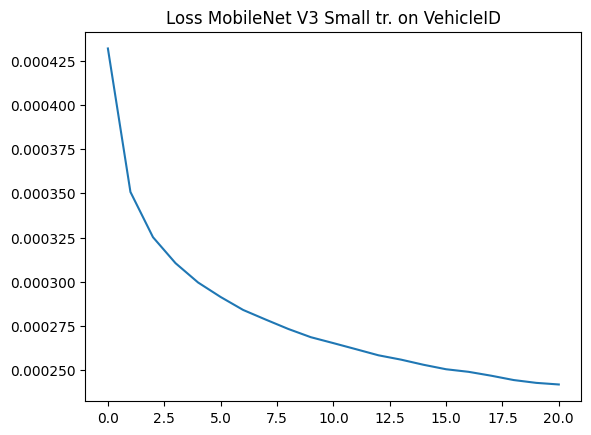

In [ ]:
# MAIN CODE
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(DEVICE_NOTCPU)
print(f'Selected device: {device}')


args_path_weights = "baseline/Hybrid_4B_new/"
args_re_rank = False

with open(args_path_weights + "config.yaml", "r") as stream:
        data = yaml.safe_load(stream)


model = MBR_model(class_num=data['n_classes'], n_branches=["R50", "R50", "BoT", "BoT"], losses="Classical", n_groups=0, LAI=data['LAI'], n_cams=data['n_cams'], n_views=data['n_views'])
model = model.to(device)
# model = get_model(data, device)

if data['half_precision']:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler=False

train_transform = transforms.Compose([
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Pad(10),
                transforms.RandomCrop((data['y_length'], data['x_length'])),
                transforms.RandomHorizontalFlip(p=data['p_hflip']),
                transforms.Normalize(data['n_mean'], data['n_std']),
                transforms.RandomErasing(p=data['p_rerase'], value=0),
])
teste_transform = transforms.Compose([
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])


#load the dataset
data_train, data_q, data_g = getDatasetInParts("data/VehicleID_V1.0/", data, test_transform=teste_transform, train_transform=train_transform, dataset='VehicleID')


# One of the saved weights last.pt best_CMC.pt best_mAP.pt
path_weights = args_path_weights + 'best_mAP.pt'

try:
    model.load_state_dict(torch.load(path_weights, map_location=device))
except RuntimeError:
### nn.Parallel adds "module." to the dict names. Although like said nn.Parallel can incur in weird results in some cases
    tmp = torch.load(path_weights, map_location=device)
    tmp = OrderedDict((k.replace("module.", ""), v) for k, v in tmp.items())
    model.load_state_dict(tmp)

teacher = model

teacher_params_count = sum(p.numel() for p in teacher.parameters())

student = LightNN_MBR_4B_Hybrid(class_num=data['n_classes'], n_branches=[], losses="LBS", n_groups=4, LAI=data['LAI'], n_cams=data['n_cams'], n_views=data['n_views'])
# load up the already trained weights on veriwild
student.load_state_dict(torch.load('drive/MyDrive/KNN/results/light_MV3Small_correct_79_2024_05_10_06_42_40.pth', map_location=device))

student_params_count = sum(p.numel() for p in student.parameters())

print("Teacher parameters count:", teacher_params_count)
print("Student parameters count:", student_params_count)
print("Student network has {:.2%} of teacher parameters".format(student_params_count / teacher_params_count))

if data["LAI"]:
    raise NotImplementedError("Original model is better of LAI, see article")

teacher.to(device)
student.to(device)

# Get the current time in Unix format
unix_time = int(time.time())

# How many epochs should run
epochs_count = 21

# Training student
list_of_loss = train_knowledge_distillation(teacher, student, data_train, epochs_count, device, data['gamma_ce'], data['alpha_ce'], unix_time=unix_time)

plt.plot(list_of_loss)
plt.title("Loss MobileNet V3 Small tr. on VehicleID")
plt.show()
